## Multi-fidelity classification using Gaussian processes: Accelerating the prediction of large-scale computational models

Francisco Sahli Costabal, Paris Perdikaris, Ellen Kuhl and Daniel E. Hurtado

This code implements a Gaussian process multi-fidelity classifier in pyMC3. There are four types of classifiers available:
- Gaussian process classifier: ``GPclassifier``
- Sparse Gaussian process classifier: ``SGPclassifier``
- Multi-fidelity classifier: ``MFGPclassifier``
- Sparse multi-fidelity classifier: ``SMFGPclassifier``

All the classifiers have an active learning option, where the next point is adaptively sample to improve accuracy. Use the method ``classifier.active_learning(N = 10)``.

Dependencies:
- pyMC3: https://docs.pymc.io
- pyDOE: ``pip install pydoe``
- matplotlib, numpy, scipy

All the details can be found in the article:

```
@article{SahliCostabal2019,
title = "Multi-fidelity classification using Gaussian processes: Accelerating the prediction of large-scale computational models",
journal = "Computer Methods in Applied Mechanics and Engineering",
volume = "357",
pages = "112602",
year = "2019",
issn = "0045-7825",
doi = "https://doi.org/10.1016/j.cma.2019.112602",
url = "http://www.sciencedirect.com/science/article/pii/S0045782519304785",
author = "Francisco Sahli Costabal and Paris Perdikaris and Ellen Kuhl and Daniel E. Hurtado"
}
```

If you are going to use this code for a publication, please cite this article.

## Demo

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from GPmodels import GPclassifier, MFGPclassifier, SMFGPclassifier, SGPclassifier
from scipy.cluster.vq import kmeans

plt.rcParams['image.cmap'] = 'coolwarm'
np.random.seed(2)

Define the functions used in the first example of the publication

In [11]:
def low_fidelity(X):
    return (0.45 + np.sin(2.2*X[:,0]*np.pi)/2.5 - X[:,1]) > 0
    
def high_fidelity(X):
    return ( 0.5 + np.sin(2.5*X[:,0]*np.pi)/3 - X[:,1]) > 0
    
def low_fidelity_boundary(X):
    return (0.45 + np.sin(2.2*X[:,0]*np.pi)/2.5)
    
def high_fidelity_boundary(X):
    return (0.5 + np.sin(2.5*X[:,0]*np.pi)/3)


Generate some data

In [3]:
# upper and lower bounds of the data. Used for normalization
# and to set the parameter space in the active learning case
lb = np.array([0,0])
ub = np.array([1,1])

N_L = 50 # number of low fidelity points
N_H = 10 # number of high fidelity points
X_L= lhs(2,N_L) # generate data with a Latin hypercube desing
labels_low = low_fidelity(X_L)
Y_L = 1.0*labels_low

# to generate the high fidelity data we choose some points
# from both of classes in the low fidelity data
ind1 = np.where(Y_L > 0)[0]
ind0 = np.where(Y_L == 0)[0]

X_H1 = X_L[np.random.choice(ind1, N_H/2, replace = False)]
X_H0 = X_L[np.random.choice(ind0, N_H/2, replace = False)]

X_H = np.concatenate((X_H1, X_H0))

labels_high = high_fidelity(X_H)
Y_H = 1.0*labels_high

X_test = lhs(2,1000) # to test the accuracy

... and plot it

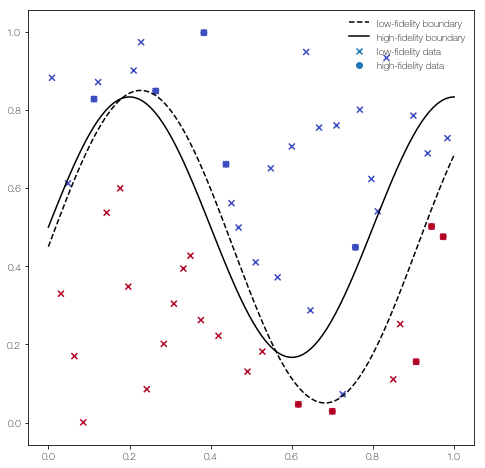

In [4]:
fig = plt.figure()
fig.set_size_inches((8,8))

plt.scatter(X_L[:,0], X_L[:,1], c = Y_L, marker = 'x', label = 'low-fidelity data')
plt.scatter(X_H[:,0], X_H[:,1], c = Y_H, label = 'high-fidelity data')

x = np.linspace(0, 1, 100)[:,None]

plt.plot(x, low_fidelity_boundary(x), 'k--', label = 'low-fidelity boundary')
plt.plot(x , high_fidelity_boundary(x), 'k', label = 'high-fidelity boundary')

plt.legend(frameon = False)



## Gaussian process classifier
Train the single fidelity classifier on the low fidelity data

In [5]:
GPc = GPclassifier(X_L, Y_L, lb, ub, low_fidelity, X_test = X_test)
# the low_fidelity function is needed for active learning. 
# otherwise set to None
GPc.create_model()
GPc.sample_model()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/fsc/anaconda/envs/ml/lib/python2.7/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [fp_rotated_, eta_L, l_L]
The number of effective samples is smaller than 25% for some parameters.


100%|██████████| 500/500 [00:38<00:00, 12.93it/s]


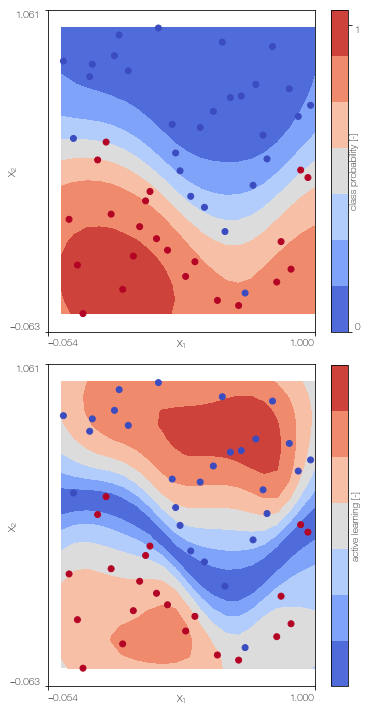

In [6]:
GPc.plot() # only works for 2D

## Sparse Gaussian process classifier
Train the sparse single fidelity classifier on the low fidelity data

In [7]:
X_Lu = kmeans(X_L,30)[0] # k-means clustering to obtain the position of the inducing points

SGPc = SGPclassifier(X_L, Y_L, X_Lu, lb, ub, low_fidelity, X_test = X_test)
# the low_fidelity function is needed for active learning. 
# otherwise set to None

In [8]:
SGPc.create_model()
SGPc.sample_model()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [fp_rotated_, u_rotated_, eta_L, l_L]
The number of effective samples is smaller than 25% for some parameters.


100%|██████████| 500/500 [00:49<00:00, 10.03it/s]


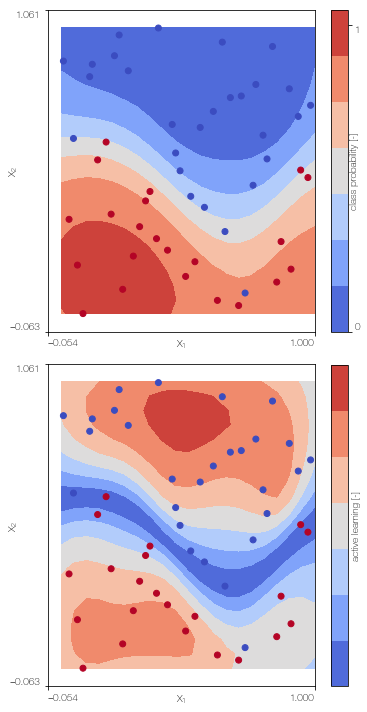

In [9]:
SGPc.plot() # only works for 2D

## Multi-fidelity Gaussian process classifier
Train the multi-fidelity classifier on low fidelity and high fidelity data

In [10]:
MFGPc = MFGPclassifier(X_L, Y_L, X_H, Y_H, lb, ub, high_fidelity, X_test = X_test)
# the high_fidelity function is needed for active learning. 
# otherwise set to None
MFGPc.create_model()
MFGPc.sample_model()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [fp_rotated_, eta_H, delta, l_H, eta_L, l_L]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


100%|██████████| 500/500 [00:40<00:00, 12.22it/s]


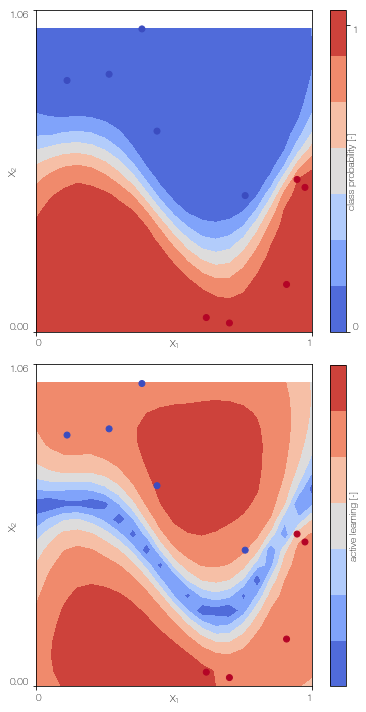

In [12]:
MFGPc.plot()

## Sparse ulti-fidelity Gaussian process classifier
Train the sparse multi-fidelity classifier on low fidelity and high fidelity data

In [13]:
X_Lu = kmeans(X_L,30)[0] # k-means clustering to obtain the position of the inducing points
X_Hu = X_H # we use the high fidelity points as inducing points as well because there only 10.

SMFGPc = SMFGPclassifier(X_L, Y_L, X_H, Y_H, X_Lu, X_Hu, lb, ub, high_fidelity, X_test = X_test)

In [14]:
SMFGPc.create_model()
SMFGPc.sample_model()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [fp_rotated_, u_rotated_, eta_H, delta, l_H, eta_L, l_L]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


100%|██████████| 500/500 [01:32<00:00,  6.08it/s]


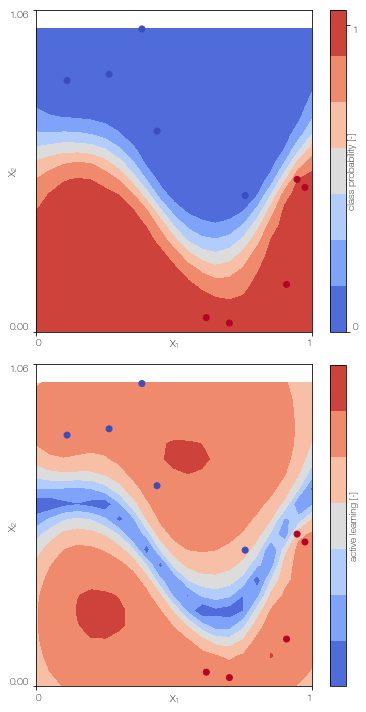

In [15]:
SMFGPc.plot()